In [1]:
import warnings

warnings.filterwarnings("ignore")

---

# 2. Transformers in `sktime`

## 2.1 Wherefore transformers?

or: why sktime transformers will improve your life!

(disclaimer: not the same product as deep learning transformers)

suppose we want to forecast this well-known dataset
(airline passengers by year in a fixed scope)

/home/codespace/.python/current/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

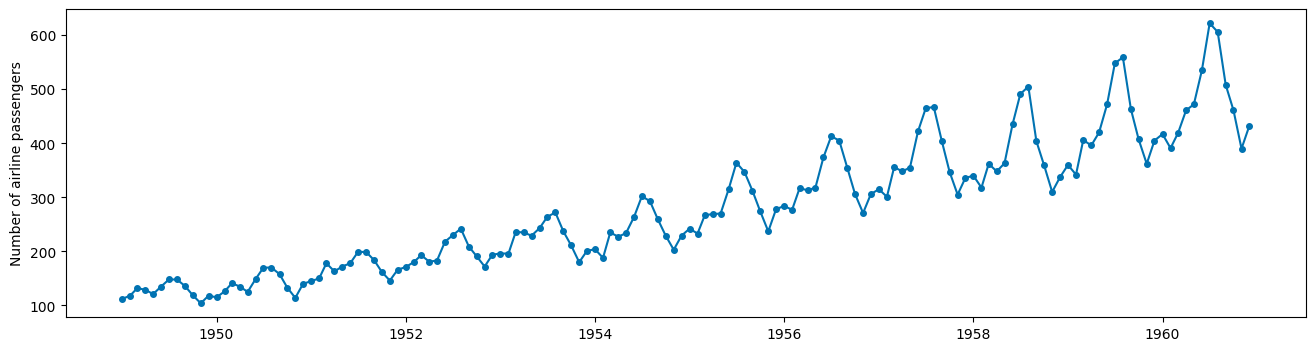

In [1]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()
plot_series(y)

observations:

* there is seasonal periodicity, 12 month period
* seasonal periodicity looks multiplicative (not additive) to trend

idea: forecast might be easier

* with seasonality removed
* on logarithmic value scale (multiplication becomes addition)

### Naive approach - don't do this at home!

Maybe doing this manually step by step is a good idea?

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

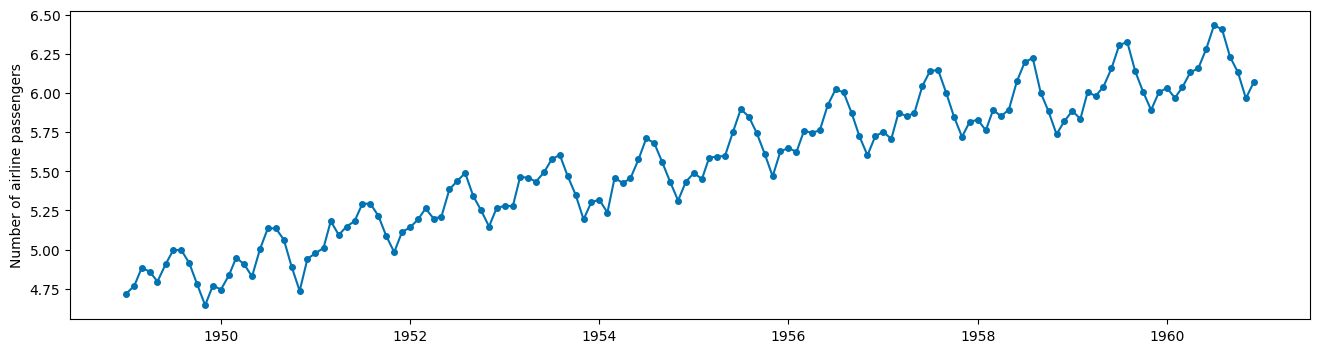

In [2]:
import numpy as np

# compute the logarithm
logy = np.log(y)

plot_series(logy)

this looks additive now!

ok, what next - deaseasonalization

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

# apply this to y
# wait no, to logy

seasonal_result = seasonal_decompose(logy, period=12)

trend = seasonal_result.trend
resid = seasonal_result.resid
seasonal = seasonal_result.seasonal

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='trend'>)

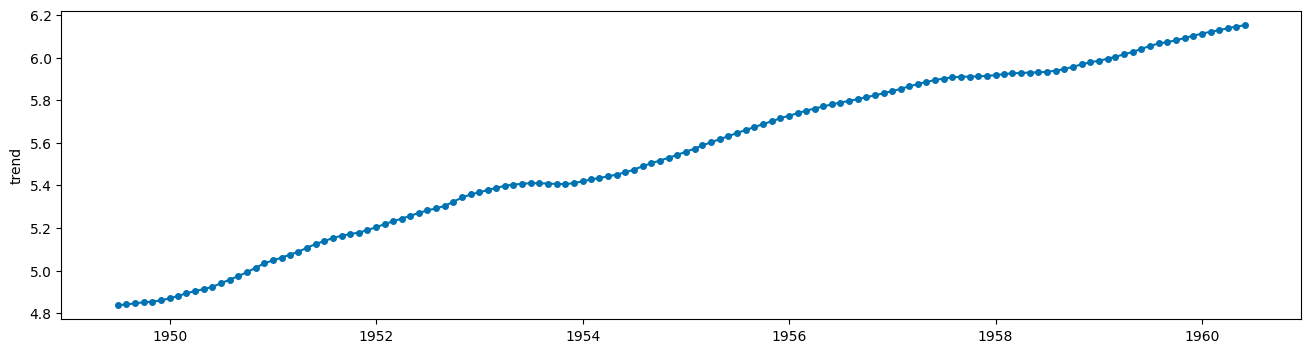

In [4]:
plot_series(trend)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='seasonal'>)

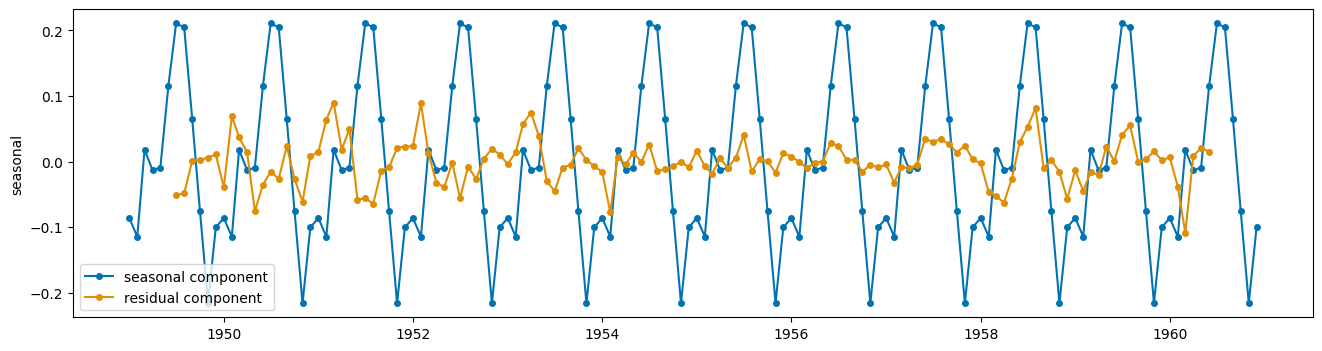

In [5]:
plot_series(seasonal, resid, labels=["seasonal component", "residual component"])

ok, now the forecast!

... of what ??

ah yes, residual plus trend, because seasonal just repeats itself

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

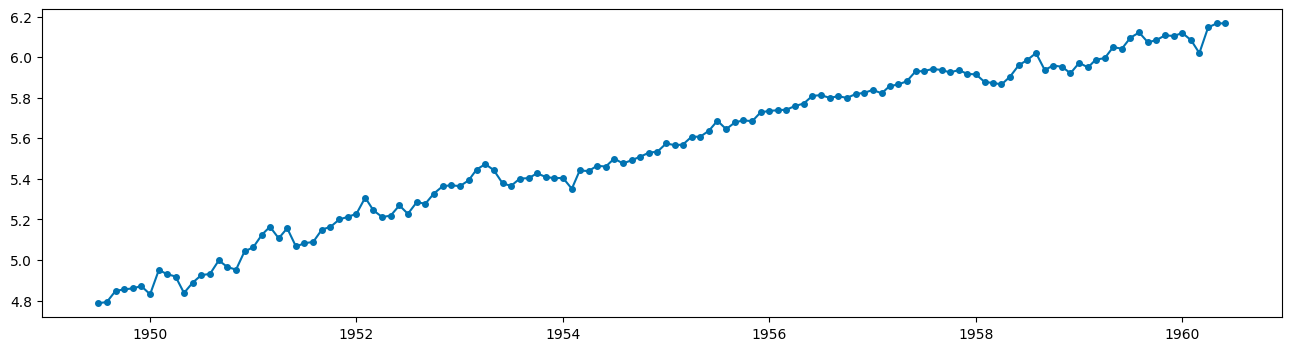

In [6]:
# forecast this:
plot_series(trend + resid)

In [7]:
# this has nans??
trend

1949-01   NaN
1949-02   NaN
1949-03   NaN
1949-04   NaN
1949-05   NaN
           ..
1960-08   NaN
1960-09   NaN
1960-10   NaN
1960-11   NaN
1960-12   NaN
Freq: M, Name: trend, Length: 144, dtype: float64

In [8]:
# ok, forecast this instead then:
y_to_forecast = logy - seasonal

# phew, no nans!
y_to_forecast

1949-01    4.804314
1949-02    4.885097
1949-03    4.864689
1949-04    4.872858
1949-05    4.804757
             ...   
1960-08    6.202368
1960-09    6.165645
1960-10    6.208669
1960-11    6.181992
1960-12    6.168741
Freq: M, Length: 144, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

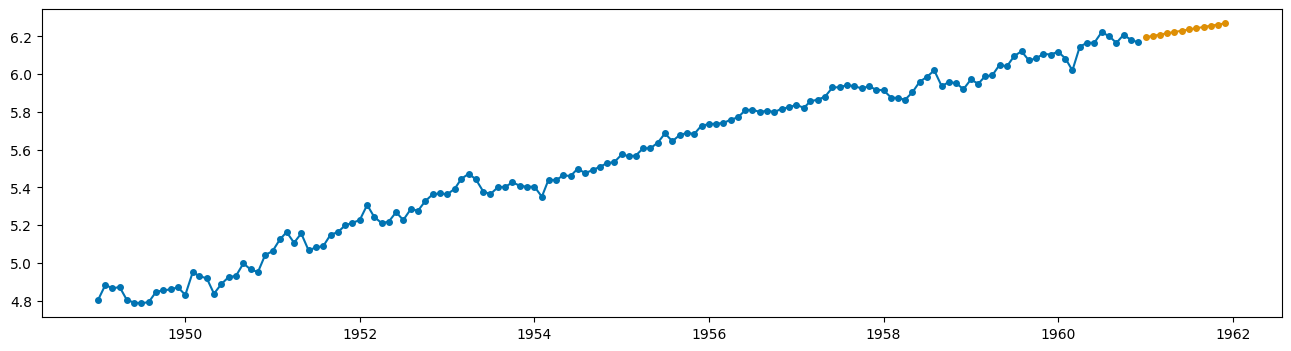

In [9]:
from sktime.forecasting.trend import PolynomialTrendForecaster

f = PolynomialTrendForecaster(degree=2)
f.fit(y_to_forecast, fh=list(range(1, 13)))
y_fcst = f.predict()

plot_series(y_to_forecast, y_fcst)

looks reasonable!

Now to turn this into a forecast of the original y ...

* add seasonal
* invert the logarithm

In [10]:
y_fcst

1961-01    6.195931
1961-02    6.202857
1961-03    6.209740
1961-04    6.216580
1961-05    6.223378
1961-06    6.230132
1961-07    6.236843
1961-08    6.243512
1961-09    6.250137
1961-10    6.256719
1961-11    6.263259
1961-12    6.269755
Freq: M, dtype: float64

In [11]:
y_fcst_orig = y_fcst + seasonal[0:12]
y_fcst_orig_orig = np.exp(y_fcst_orig)

y_fcst_orig_orig

1949-01   NaN
1949-02   NaN
1949-03   NaN
1949-04   NaN
1949-05   NaN
1949-06   NaN
1949-07   NaN
1949-08   NaN
1949-09   NaN
1949-10   NaN
1949-11   NaN
1949-12   NaN
1961-01   NaN
1961-02   NaN
1961-03   NaN
1961-04   NaN
1961-05   NaN
1961-06   NaN
1961-07   NaN
1961-08   NaN
1961-09   NaN
1961-10   NaN
1961-11   NaN
1961-12   NaN
Freq: M, dtype: float64

ok, that did not work. Something something pandas indices??

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

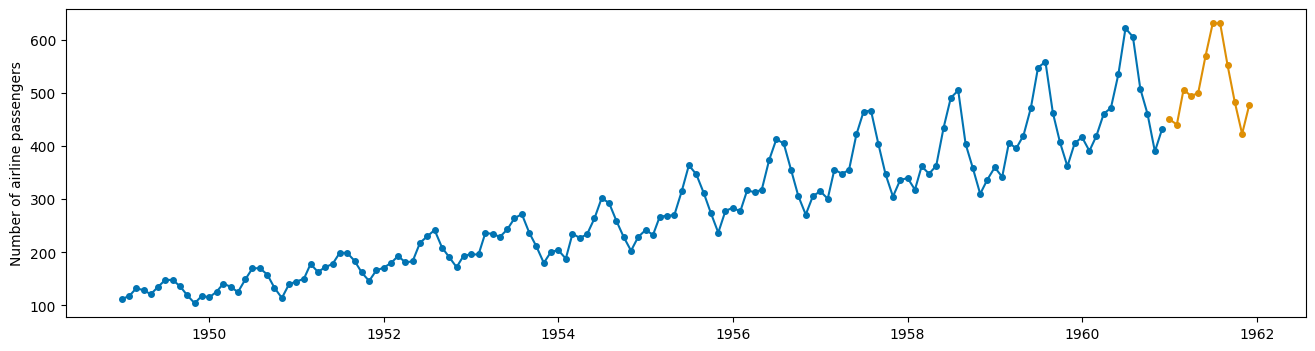

In [12]:
y_fcst_orig = y_fcst + seasonal[0:12].values
y_fcst_orig_orig = np.exp(y_fcst_orig)

plot_series(y, y_fcst_orig_orig)

ok, done! and it only took us 10 years.

Maybe there is a better way?

### Slightly less naive approach - use `sktime` transformers (badly)

Ok, surely there is a way where I don't have to fiddle with wildly varying interfaces of every step.

Solution: use transformers!

Same interface at every step!

In [13]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer


y = load_airline()

t_log = LogTransformer()
ylog = t_log.fit_transform(y)

t_deseason = Deseasonalizer(sp=12)
y_deseason = t_deseason.fit_transform(ylog)

f = PolynomialTrendForecaster(degree=2)
f.fit(y_deseason, fh=list(range(1, 13)))
y_fcst = f.predict()

hm, but now we need to invert the transformations...

fortunately transformers have an inverse transform, standard interface point

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

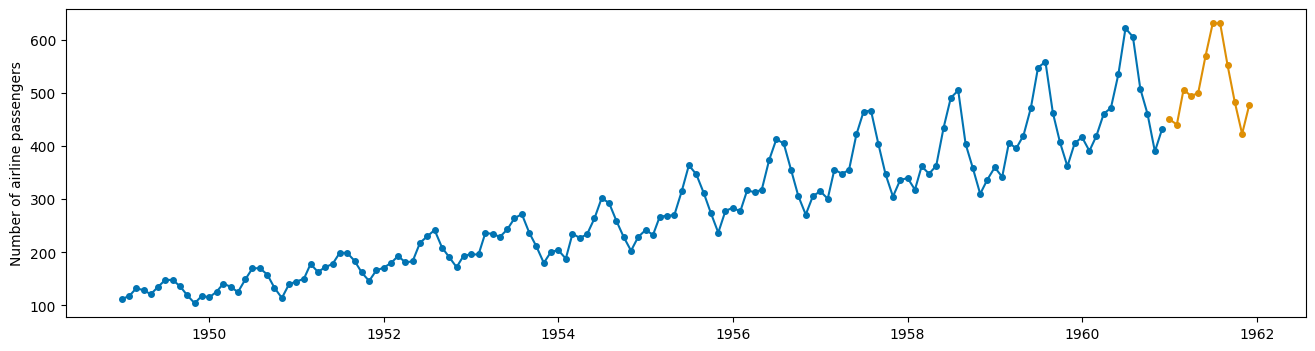

In [14]:
y_fcst_orig = t_deseason.inverse_transform(y_fcst)
# the deseasonalizer remembered the seasonality component! nice!

y_fcst_orig_orig = t_log.inverse_transform(y_fcst_orig)

plot_series(y, y_fcst_orig_orig)

### Expert approach - use `sktime` transformers with pipelines!

Bragging rights included.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

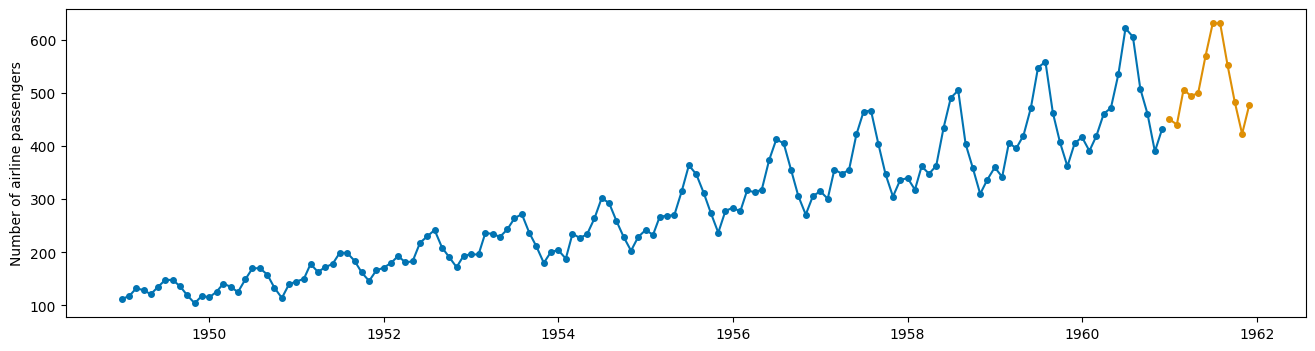

In [15]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

f = LogTransformer() * Deseasonalizer(sp=12) * PolynomialTrendForecaster(degree=2)

f.fit(y, fh=list(range(1, 13)))
y_fcst = f.predict()

plot_series(y, y_fcst)

what happened here?

The "chain" operator `*` creates a "forecasting pipeline"

Has the same interface as all other forecasters! No additional data fiddling!

Transformers "slot in" as standardized components.

In [16]:
f

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   PolynomialTrendForecaster(degree=2)])

Let's look at this in more detail:

* `sktime` transformers interface
* `sktime` pipeline building

## 2.2 Transformers - interface and features

* transformer interface
* transformer types
* searching transformers by type
* broadcasting/vectorization to panel & hierarchical data
* transformers and pipelines

### 2.2.1 What are transformers? <a class="anchor" id="section_1_1"></a>

Transformer = modular data processing steps commonly used in machine learning

("transformer" used in the sense of `scikit-learn`)

Transformers are estimators that:

* are fitted to a batch of data via `fit(data)`, changing its state
* are applied to another batch of data via `transform(X)`, producing transformed data
* may have an `inverse_transform(X)`

In `sktime`, input `X` to `fit` and `transform` is typically a time series or a panel (collection of time series).

Basic use of an `sktime` time series transformer is as follows:

In [17]:
# 1. prepare the data
from sktime.utils._testing.series import _make_series

X = _make_series()
X_train = X[:7]
X_test = X[7:12]
# X_train and X_test are both pandas.Series

X_train, X_test

(2000-01-01    1.652787
 2000-01-02    4.031220
 2000-01-03    2.611567
 2000-01-04    3.322912
 2000-01-05    3.390822
 2000-01-06    3.525682
 2000-01-07    2.560334
 Freq: D, dtype: float64,
 2000-01-08    3.710051
 2000-01-09    1.919566
 2000-01-10    2.453905
 2000-01-11    1.334442
 2000-01-12    2.747286
 Freq: D, dtype: float64)

In [18]:
# 2. construct the transformer
from sktime.transformations.series.boxcox import BoxCoxTransformer

# trafo is an sktime estimator inheriting from BaseTransformer
# Box-Cox transform with lambda parameter fitted via mle
trafo = BoxCoxTransformer(method="mle")

In [19]:
# 3. fit the transformer to training data
trafo.fit(X_train)

# 4. apply the transformer to transform test data
# Box-Cox transform with lambda fitted on X_train
X_transformed = trafo.transform(X_test)

X_transformed

2000-01-08    5.380253
2000-01-09    1.246540
2000-01-10    2.254004
2000-01-11    0.378926
2000-01-12    2.890838
Freq: D, dtype: float64

If the training and test set is the same, step 3 and 4 can be carried out more concisely (and sometimes more efficiently) by using `fit_transform`:

In [20]:
# 3+4. apply the transformer to fit and transform on the same data, X
X_transformed = trafo.fit_transform(X)

### 2.2.2 Different types of transformers <a class="anchor" id="section_1_2"></a>

`sktime` distinguishes different types of transformer, depending on the input type of `fit` and `transform`, and the output type of `transform`.

Transformers differ by:

* making use of an additional `y` argument in `fit` or `transform`
* whether the input to `fit` and `transform` is a single time series, a collection of time series, or scalar values (data frame row)
* whether the output of `transform` is a single time series, a collection of time series, or scalar values (data frame row)
* whether the input to `fit` and `transform` are one object or two. Two objects as input and a scalar output means the transformer is a distance or kernel function.

More detail on this is given in the glossary (section 2.3).

To illustrate the difference, we compare two transformers with different output:

* the Box-Cox transformer `BoxCoxTrannsformer`, which transforms a time series to a time series
* the summary transformer `SummaryTransformer`, which transforms a time series to scalars such as the mean


In [21]:
# constructing the transformer
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.summarize import SummaryTransformer
from sktime.utils._testing.series import _make_series

# getting some data
# this is one pandas.Series
X = _make_series(n_timepoints=10)

# constructing the transformers
boxcox_trafo = BoxCoxTransformer(method="mle")
summary_trafo = SummaryTransformer()

In [22]:
# this produces a pandas Series
boxcox_trafo.fit_transform(X)

2000-01-01    1.838675
2000-01-02    1.093379
2000-01-03    0.680495
2000-01-04    1.956386
2000-01-05    0.000000
2000-01-06    1.316809
2000-01-07    2.566118
2000-01-08    0.400775
2000-01-09    1.660337
2000-01-10    1.243415
Freq: D, dtype: float64

In [23]:
# this produces a pandas.DataFrame row
summary_trafo.fit_transform(X)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,2.790072,1.239691,1.0,5.123073,1.39549,1.938545,2.671661,3.560785,3.99108


For time series transformers, the metadata tags describe the expected output of `transform`:

In [28]:
boxcox_trafo.get_tag("scitype:transform-output")

'Series'

In [29]:
summary_trafo.get_tag("scitype:transform-output")

'Primitives'

To find transformers, use `all_estimators` and filter by tags:

* `"scitype:transform-output"` - the output scitype. `Series` for time series, `Primitives` for primitive features (float, categories), `Panel` for collections of time series.
* `"scitype:transform-input"` - the input scitype. `Series` for time series.
* `"scitype:instancewise"` - If `True`, vectorized operation per series. If `False`, uses multiple time series non-trivially.

Example: find all transformers that output time series

### 2.2.4 Transformers as pipeline components <a class="anchor" id="section_1_4"></a>

`sktime` transformers can be pipelined with any other `sktime` estimator type, including forecasters, classifiers, and other transformers.

Pipelines = estimators of the same type, same interface as specialized class

pipeline build operation: `make_pipeline` or via `*` dunder

Pipelining `pipe = trafo * est` produces `pipe` of same type as `est`.

In `pipe.fit`, first `trafo.fit_transform`, then `est.fit` is executed on the result.

In `pipe.predict`, first `trafo.transform`, then `est.predict` is executed.

(the arguments that are piped differ by type and can be looked up in the docstrings of pipeline classes, or specialized tutorials)

#### Example 1: forecaster pipeline

we have seen this example above

In [24]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

pipe = LogTransformer() * Deseasonalizer(sp=12) * PolynomialTrendForecaster(degree=2)

pipe

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   PolynomialTrendForecaster(degree=2)])

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

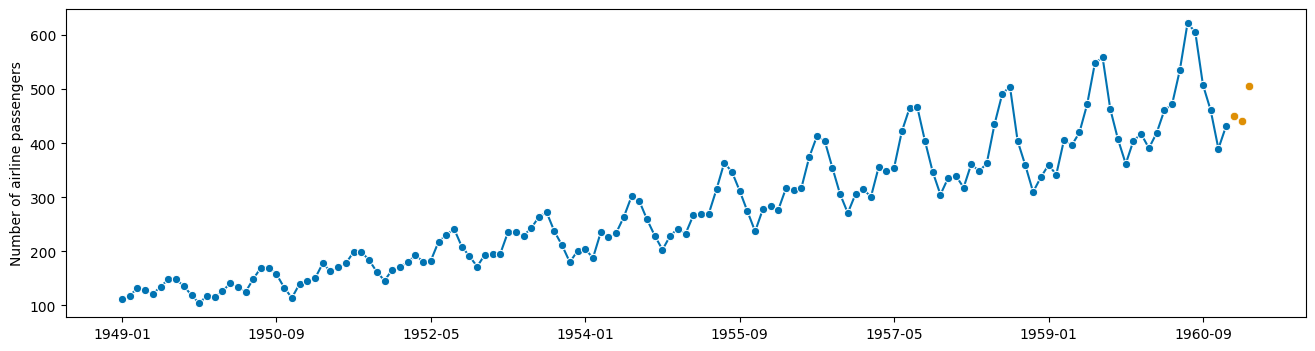

In [34]:
# this is a forecaster with the same interface as Polynomial Trend Forecaster
pipe.fit(y, fh=[1, 2, 3])
y_pred = pipe.predict()

plot_series(y, y_pred)